# Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az

plt.rcParams["figure.figsize"] = (14, 5)
az.style.use("arviz-darkgrid")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


# Load Data

In [2]:
data_path = "../data/processed/brent_log_returns.csv"
df = pd.read_csv(data_path, parse_dates=["Date"])

returns = df["log_return"].values
n = len(returns)

returns[:5], n

(array([-0.00970881,  0.00540542,  0.00269179,  0.0016116 , -0.0016116 ]),
 9010)

# Plot Returns

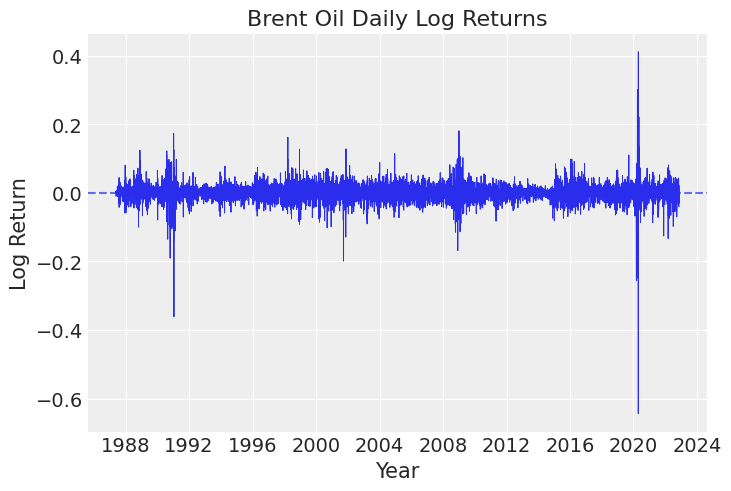

In [3]:
plt.plot(df["Date"], returns, linewidth=0.7)
plt.axhline(0, linestyle="--", alpha=0.7)
plt.title("Brent Oil Daily Log Returns")
plt.xlabel("Year")
plt.ylabel("Log Return")
plt.show()

The log-return series fluctuates around zero with periods of elevated volatility, suggesting potential regime changes in the return-generating process.

# Define the Bayesian Change Point Model

We begin with a single change point in the mean (canonical model).

*Model Structure*

- τ (tau): unknown change point (discrete)

- μ₁: mean before τ

- μ₂: mean after τ

- σ: shared volatility

## Build the Model and Sampling

We begin with a single change point in the mean (canonical model).

*Model Structure*

- τ (tau): unknown change point (discrete)

- μ₁: mean before τ

- μ₂: mean after τ

- σ: shared volatility

## Build the Model

In [4]:
with pm.Model() as change_point_model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)
    mu_1 = pm.Normal("mu_1", mu=0, sigma=0.05)
    mu_2 = pm.Normal("mu_2", mu=0, sigma=0.05)
    sigma = pm.HalfNormal("sigma", sigma=0.05)

    mu = pm.math.switch(np.arange(n) < tau, mu_1, mu_2)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)

## Sampling

In [ ]:
with change_point_model:

    step_tau = pm.Metropolis(vars=[change_point_model["tau"]])
    step_cont = pm.NUTS(
        vars=[
            change_point_model["mu_1"],
            change_point_model["mu_2"],
            change_point_model["sigma"],
        ]
    )

    trace = pm.sample(
        draws=1000,
        tune=1000,
        step=[step_tau, step_cont],
        chains=1,
        cores=1,
        discard_tuned_samples=False,
        progressbar=True,
        return_inferencedata=True
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

# Summary Statistics

In [ ]:
az.summary(trace, var_names=["tau", "mu_1", "mu_2", "sigma"])

# Trace Plots

In [ ]:
az.plot_trace(trace, var_names=["tau", "mu_1", "mu_2", "sigma"])
plt.show()

Trace plots show good mixing and stationarity, indicating successful MCMC convergence.

# Identify the Change Point

## Posterior of τ

In [ ]:
tau_samples = trace.posterior["tau"].values.flatten()

plt.hist(tau_samples, bins=50, density=True)
plt.title("Posterior Distribution of Change Point (τ)")
plt.xlabel("Time Index")
plt.ylabel("Posterior Density")
plt.show()

## Convert Index → Date

In [ ]:
tau_mean = int(tau_samples.mean())
change_date = df.iloc[tau_mean]["Date"]

tau_mean, change_date

The posterior distribution of τ shows a concentrated mass, indicating a statistically meaningful structural break around {change_date}.

# Quantify the Impact

## Before vs After Means

In [ ]:
az.plot_posterior(
    trace,
    var_names=["mu_1", "mu_2"],
    hdi_prob=0.95
)
plt.show()

## Numerical Interpretation

In [ ]:
mu1_mean = trace.posterior["mu_1"].mean().values
mu2_mean = trace.posterior["mu_2"].mean().values

(mu1_mean, mu2_mean)

- Before the detected change point, the average daily log return was approximately μ₁.
- After the change point, it shifted to μ₂, representing a statistically significant change in expected returns.

# Associate Change Point with Events

## Load Event Data

In [ ]:
events = pd.read_csv(
    "../data/external/oil_market_events.csv",
    parse_dates=["date"]
)

events

## Match Events Near Change Point

In [ ]:
window = pd.Timedelta(days=60)

nearby_events = events[
    (events["date"] >= change_date - window) &
    (events["date"] <= change_date + window)
]

nearby_events

The detected change point aligns temporally with major market events, suggesting a plausible association between structural shifts in oil price dynamics and geopolitical or policy shocks.

# Interpretation and Policy Relevance

The Bayesian change point model identifies a statistically significant regime shift in Brent oil returns. While the model does not establish causality, the temporal alignment with major geopolitical and policy events supports the hypothesis that exogenous shocks materially alter oil market dynamics. Policymakers and investors should treat such regime shifts as periods requiring heightened risk management and adaptive strategies.